# Problem Statement: To create a Model which can predict whether company will go bankrupt or not based on given features and make recommendations accordingly to avoid its bankruptcy

In [1]:
#Importing of necessary libraries
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import ppscore as pps
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
import pickle
from statistics import mode
import streamlit as st

Data Collection

In [2]:
bankrupt = pd.read_csv('bankruptcy-prevention.csv',sep=';')
bankrupt

,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk,class
0,0.5,1.0,0.0,0.0,0.0,0.5,bankruptcy
1,0.0,1.0,0.0,0.0,0.0,1.0,bankruptcy
2,1.0,0.0,0.0,0.0,0.0,1.0,bankruptcy
3,0.5,0.0,0.0,0.5,0.0,1.0,bankruptcy
4,1.0,1.0,0.0,0.0,0.0,1.0,bankruptcy
...,...,...,...,...,...,...,...
245,0.0,1.0,1.0,1.0,1.0,1.0,non-bankruptcy
246,1.0,1.0,0.5,1.0,1.0,0.0,non-bankruptcy
247,0.0,1.0,1.0,0.5,0.5,0.0,non-bankruptcy
248,1.0,0.0,0.5,1.0,0.5,0.0,non-bankruptcy


Data Cleaning

In [3]:
#Checking the null values
bankrupt.isnull().sum()

industrial_risk           0
 management_risk          0
 financial_flexibility    0
 credibility              0
 competitiveness          0
 operating_risk           0
 class                    0
dtype: int64

In [4]:
#Checking the duplicated values
bankrupt.duplicated().sum()
#there are 147 duplicated values found but it can contain important information and its percentage is also high so we are not deleting this

147

<AxesSubplot:>

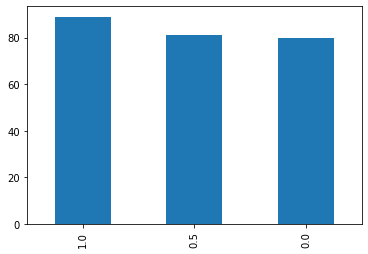

In [5]:
#Outlier detection
bankrupt['industrial_risk'].value_counts().plot(kind = 'bar')
#As all the values contains values of 0,0.5 and 1 and data is discrete so no outliers are there.

{'whiskers': [<matplotlib.lines.Line2D at 0x233acdffb50>,
 'caps': [<matplotlib.lines.Line2D at 0x233ace151f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x233acdff700>],
 'medians': [<matplotlib.lines.Line2D at 0x233ace15910>],
 'fliers': [<matplotlib.lines.Line2D at 0x233ace15cd0>],
 'means': []}

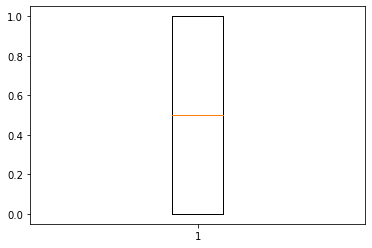

In [6]:
plt.boxplot(bankrupt.industrial_risk)

In [7]:
#After looking at data no unnecessary columns like some identity number or like that is observed. If it is not important is can be detected in feature engineering

Exploratory Data Analysis

In [8]:
bankrupt.describe() #checking for the min max,median values and iqr

,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.518000,0.614000,0.376000,0.470000,0.476000,0.570000
std,0.411526,0.410705,0.401583,0.415682,0.440682,0.434575
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
75%,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
mode(bankrupt.industrial_risk)

1.0

In [10]:
#Checking the data types
bankrupt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   industrial_risk         250 non-null    float64
 1    management_risk        250 non-null    float64
 2    financial_flexibility  250 non-null    float64
 3    credibility            250 non-null    float64
 4    competitiveness        250 non-null    float64
 5    operating_risk         250 non-null    float64
 6    class                  250 non-null    object 
dtypes: float64(6), object(1)
memory usage: 13.8+ KB


In [11]:
#Checking column names
bankrupt.columns

Index(['industrial_risk', ' management_risk', ' financial_flexibility',
       ' credibility', ' competitiveness', ' operating_risk', ' class'],
      dtype='object')

In [12]:
#Space removal from column names
bankrupt.columns=bankrupt.columns.str.strip()

In [13]:
#Ensuring space removal
bankrupt.columns

Index(['industrial_risk', 'management_risk', 'financial_flexibility',
       'credibility', 'competitiveness', 'operating_risk', 'class'],
      dtype='object')

In [14]:
#Checking mode for all features
print('mode for industrial risk is ',mode(bankrupt.industrial_risk))
print('mode for management risk is ',mode(bankrupt.management_risk))
print('mode for financial flexibility is ',mode(bankrupt.financial_flexibility))
print('mode for credibility is ',mode(bankrupt.credibility))
print('mode for competitiveness is ',mode(bankrupt.competitiveness))
print('mode for operating risk is ',mode(bankrupt.operating_risk))

mode for industrial risk is  1.0
mode for management risk is  1.0
mode for financial flexibility is  0.0
mode for credibility is  0.0
mode for competitiveness is  0.0
mode for operating risk is  1.0


In [15]:
#Using the label encoding to target variable class so as to convert object type to intergers
label_encoder = preprocessing.LabelEncoder()
bankrupt['class']=label_encoder.fit_transform(bankrupt['class'])

In [16]:
bankrupt

,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk,class
0,0.5,1.0,0.0,0.0,0.0,0.5,0
1,0.0,1.0,0.0,0.0,0.0,1.0,0
2,1.0,0.0,0.0,0.0,0.0,1.0,0
3,0.5,0.0,0.0,0.5,0.0,1.0,0
4,1.0,1.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...
245,0.0,1.0,1.0,1.0,1.0,1.0,1
246,1.0,1.0,0.5,1.0,1.0,0.0,1
247,0.0,1.0,1.0,0.5,0.5,0.0,1
248,1.0,0.0,0.5,1.0,0.5,0.0,1


<AxesSubplot:ylabel='None'>

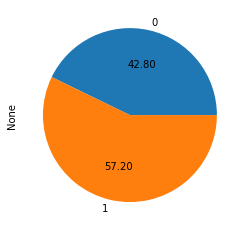

In [17]:
#Checking whether data is balanced or not (0 for the bankrupt and 1 for the not bankrupt)
bankrupt.groupby(['class']).size().plot(kind='pie',autopct='%0.2f')

Feature Engineering

In [18]:
#Checking correlation between features and class using chi2 method
chi2score,pvalue= chi2(bankrupt.iloc[::,0:6],bankrupt.iloc[::,6:7])

In [21]:
x= bankrupt.iloc[::,0:6]
y=bankrupt.iloc[::,6:7]

In [22]:
#Checking important features using RFE
model = LogisticRegression()
rfe = RFE(model, 3)
fit = rfe.fit(x,y)
fit.ranking_

array([3, 2, 1, 1, 1, 4])

In [23]:
chi2d= pd.DataFrame(['industrial_risk', 'management_risk', 'financial_flexibility','credibility', 'competitiveness', 'operating_risk'])
chi2d['chi2score'] = chi2score
chi2d['pvalue'] = pvalue
chi2d=chi2d.rename(columns={0:'features'})
chi2d['RFE']= fit.ranking_
chi2d
#As from the scores it is clear that feature 'financial_flexibility','credibility', 'competitiveness' are more important

,features,chi2score,pvalue,RFE
0,industrial_risk,4.225298,3.982561e-02,3
1,management_risk,9.407190,2.161362e-03,2
2,financial_flexibility,60.237242,8.408608e-15,1
3,credibility,52.307251,4.746188e-13,1
4,competitiveness,82.186252,1.238483e-19,1
5,operating_risk,6.458129,1.104459e-02,4


In [27]:
#To make the model simple consider these three columns and build the model.
bankrupt_new= bankrupt[['financial_flexibility','credibility', 'competitiveness', 'class']]
bankrupt_new

,financial_flexibility,credibility,competitiveness,class
0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0
3,0.0,0.5,0.0,0
4,0.0,0.0,0.0,0
...,...,...,...,...
245,1.0,1.0,1.0,1
246,0.5,1.0,1.0,1
247,1.0,0.5,0.5,1
248,0.5,1.0,0.5,1


Model Building and Deployment

In [29]:
#As our problem is categorical we will be going with the classification models. 
# Under that also we are having requirement of model having speed and which is explainable so we go with the logistic regression or decision tree
# we will also check our choosen model accuracy with the SVM,random forest and gradient boosting tree

In [30]:
#Checking the accuracy for the train test split vs cross validation to decide the method
x1= bankrupt_new.iloc[::,0:3:]
y1= bankrupt_new.iloc[::,3:4:]

In [31]:
#checking accuracy of the model for the logistic regression model with train test split and cross validation 
#Train test split
xtrain,xtest,ytrain,ytest = train_test_split(x1,y1,test_size=0.3,random_state=7)
log_model = LogisticRegression()
log_model.fit(xtrain,ytrain)
ypred_log= log_model.predict(xtest)
result= accuracy_score(ytest,ypred_log)
print(result*100)

100.0


In [32]:
#cross validation
results = cross_val_score(log_model,x,y,cv=10).mean()
results*100

99.60000000000001

In [33]:
#We will go with the train test split as it is giving good accuracy

In [41]:
#Log model
log_model = LogisticRegression()
log_model.fit(xtrain,ytrain)
ypred_log_train = log_model.predict(xtrain)
train_acc_log= accuracy_score(ytrain,ypred_log_train)
ypred_log_test= log_model.predict(xtest)
test_acc_log= accuracy_score(ytest,ypred_log_test)
print('training accuracy is',train_acc_log)
print('testing accuracy is',test_acc_log)
print(classification_report(ytrain,ypred_log_train))
print(classification_report(ytest,ypred_log_test))

training accuracy is 0.9942857142857143
testing accuracy is 1.0
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        68
           1       0.99      1.00      1.00       107

    accuracy                           0.99       175
   macro avg       1.00      0.99      0.99       175
weighted avg       0.99      0.99      0.99       175

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        36

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



In [47]:
#Decision tree classifier
dec_model = DecisionTreeClassifier()
dec_model.fit(xtrain,ytrain)
ypred_dec_train = dec_model.predict(xtrain)
train_acc_dec= accuracy_score(ytrain,ypred_dec_train)
ypred_dec_test= dec_model.predict(xtest)
test_acc_dec= accuracy_score(ytest,ypred_dec_test)
print('training accuracy is',train_acc_dec)
print('testing accuracy is',test_acc_dec)
print(classification_report(ytrain,ypred_dec_train))
print(classification_report(ytest,ypred_dec_test))

training accuracy is 1.0
testing accuracy is 0.9866666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        68
           1       1.00      1.00      1.00       107

    accuracy                           1.00       175
   macro avg       1.00      1.00      1.00       175
weighted avg       1.00      1.00      1.00       175

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        39
           1       1.00      0.97      0.99        36

    accuracy                           0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75



In [48]:
#Logistic regression model accuracy is 100% as well as recall and precision value is also 100% for the testing data
#decision tree is also giving good result but as logistic regression is giving better results we will choose logistic regression

In [49]:
#Comparing accuracy of our model along with other models which are famous for their accuracies

In [50]:
#SVM model
svm_model = svm.SVC()
svm_model.fit(xtrain,ytrain)
ypred_svm_train = svm_model.predict(xtrain)
train_acc_svm= accuracy_score(ytrain,ypred_svm_train)
ypred_svm_test= svm_model.predict(xtest)
test_acc_svm= accuracy_score(ytest,ypred_svm_test)
print(train_acc_svm)
print(test_acc_svm)

1.0
0.9866666666666667


In [51]:
#Random forest model
rf_model = RandomForestClassifier()
rf_model.fit(xtrain,ytrain)
ypred_rf_train = rf_model.predict(xtrain)
train_acc_rf= accuracy_score(ytrain,ypred_rf_train)
ypred_rf_test= rf_model.predict(xtest)
test_acc_rf= accuracy_score(ytest,ypred_rf_test)
print(train_acc_rf)
print(test_acc_rf)

1.0
0.9866666666666667


In [52]:
#bagging classifier model
bc_model = BaggingClassifier()
bc_model.fit(xtrain,ytrain)
ypred_bc_train = bc_model.predict(xtrain)
train_acc_bc= accuracy_score(ytrain,ypred_bc_train)
ypred_bc_test= bc_model.predict(xtest)
test_acc_bc= accuracy_score(ytest,ypred_bc_test)
print(train_acc_bc)
print(test_acc_bc)

1.0
0.9866666666666667


In [55]:
ada_model = AdaBoostClassifier(n_estimators = 3,random_state = 7)
ada_model.fit(xtrain,ytrain)
ypred_ada_train = ada_model.predict(xtrain)
train_acc_ada= accuracy_score(ytrain,ypred_ada_train)
ypred_ada_test= ada_model.predict(xtest)
test_acc_ada= accuracy_score(ytest,ypred_ada_test)
print(train_acc_ada)
print(test_acc_ada)

1.0
0.9866666666666667


In [80]:
#lets compare with the model which handles high data

In [56]:
#Naive bayes model
nb_model = GaussianNB()
nb_model.fit(xtrain,ytrain)
ypred_nb_train = nb_model.predict(xtrain)
train_acc_nb= accuracy_score(ytrain,ypred_nb_train)
ypred_nb_test= nb_model.predict(xtest)
test_acc_nb= accuracy_score(ytest,ypred_nb_test)
print(train_acc_nb)
print(test_acc_nb)

0.9771428571428571
0.9866666666666667


In [58]:
#lets compare our model with all these models

In [65]:
scores={"Model_Name":['Logistic regression','Decision Tree','Support vector machine','Random forest'
         ,'Bagging classifier','Adaboost classifier','Naive Bayes'],
       "Training_Accuracy":[train_acc_log,train_acc_dec,train_acc_svm,train_acc_rf,train_acc_bc,train_acc_ada,
                            train_acc_nb],
       "Testing_Accuracy":[test_acc_log,test_acc_dec,test_acc_svm,test_acc_rf,test_acc_bc,test_acc_ada,
                          test_acc_nb]}
score = pd.DataFrame(scores)
score

,Model_Name,Training_Accuracy,Testing_Accuracy
0,Logistic regression,0.994286,1.000000
1,Decision Tree,1.000000,0.986667
2,Support vector machine,1.000000,0.986667
3,Random forest,1.000000,0.986667
4,Bagging classifier,1.000000,0.986667
5,Adaboost classifier,1.000000,0.986667
6,Naive Bayes,0.977143,0.986667


Text(0.5, 1.0, 'Training Accuracy comparison')

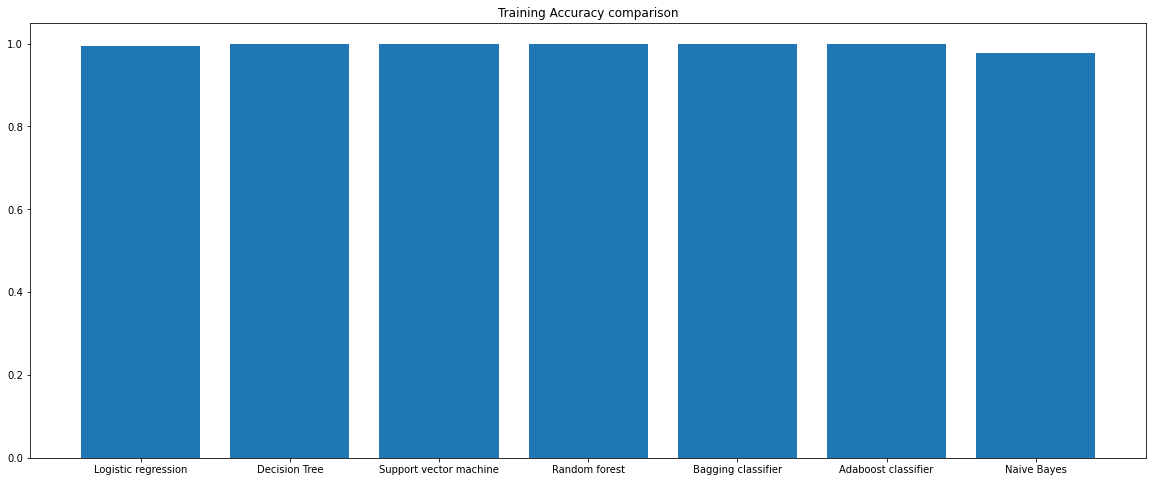

In [86]:
fig = plt.figure(figsize = (20,8))
plt.bar(score.Model_Name,score.Training_Accuracy)
plt.title('Training Accuracy comparison')

Text(0.5, 1.0, 'Testing Accuracy comparison')

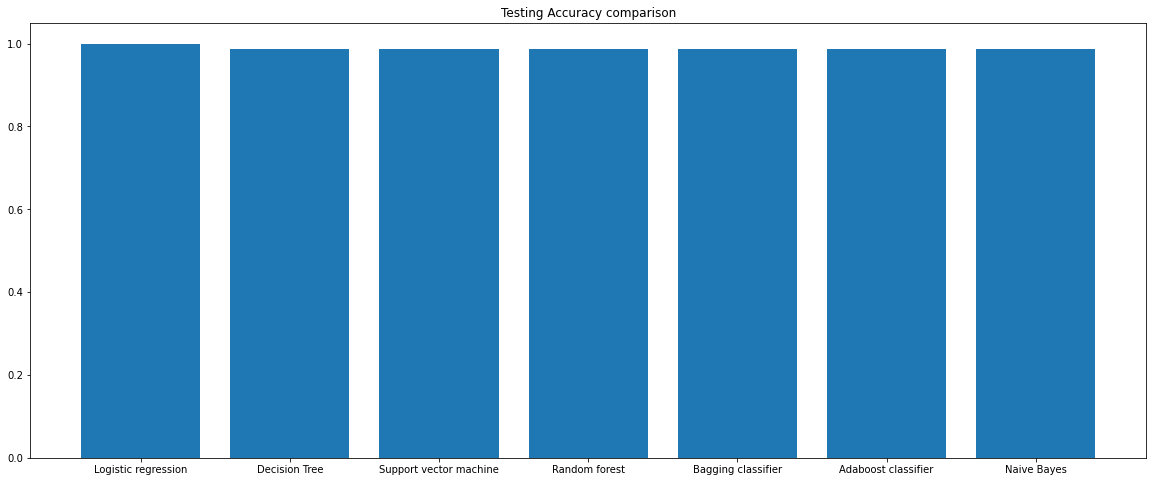

In [78]:
fig = plt.figure(figsize = (20,8))
plt.bar(score.Model_Name,score.Testing_Accuracy)
plt.title('Testing Accuracy comparison')

In [79]:
#so our model gives good testing accuracy than all other models

In [87]:
#lets do the deployment

In [2]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import ppscore as pps
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
import pickle
from statistics import mode
import streamlit as st

#data collection
bankrupt = pd.read_csv('bankruptcy-prevention.csv',sep=';')
bankrupt

#data EDA
bankrupt.columns=bankrupt.columns.str.strip()
label_encoder = preprocessing.LabelEncoder()
bankrupt['class']=label_encoder.fit_transform(bankrupt['class'])

#feature engineering
bankrupt_new= bankrupt[['financial_flexibility','credibility', 'competitiveness', 'class']]
bankrupt_new

#model building
x1= bankrupt_new.iloc[::,0:3:]
y1= bankrupt_new.iloc[::,3:4:]
xtrain,xtest,ytrain,ytest = train_test_split(x1,y1,test_size=0.3,random_state=7)
log_model = LogisticRegression()
log_model.fit(xtrain,ytrain)

#saving the model
filename= 'bankrupt_model.sav'
pickle.dump(log_model,open(filename,'wb'))

#loading the model
load_model = pickle.load(open(filename, 'rb'))
result = load_model.score(xtest, ytest)
print(result)

1.0


In [9]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import ppscore as pps
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
import pickle
from statistics import mode
import streamlit as st

st.title('Bankrupt Model')
#data collection
bankrupt = pd.read_csv('bankruptcy-prevention.csv',sep=';')
bankrupt

#data EDA
bankrupt.columns=bankrupt.columns.str.strip()
label_encoder = preprocessing.LabelEncoder()
bankrupt['class']=label_encoder.fit_transform(bankrupt['class'])

#feature engineering
bankrupt_new= bankrupt[['financial_flexibility','credibility', 'competitiveness', 'class']]

st.subheader('Input paramters')
st.write(bankrupt.iloc[::,2:5])
x1= bankrupt_new.iloc[::,0:3:]
y1= bankrupt_new.iloc[::,3:4:]

#loading the model
filename= 'bankrupt_model.sav'
load_model = pickle.load(open(filename, 'rb'))
result = load_model.score(x1, y1)
predictions =load_model.predict(x1)
print(predictions)
st.subheader('Predictions')
st.write(predictions)
predi_probability = load_model.predict_proba(x1)
print(predi_probability)
st.subheader('Prediction Probability')
st.write(predi_probability)

bankrupt_output = pd.concat([bankrupt,pd.DataFrame(predi_probability)],axis=1)
bankrupt_output.to_excel('bankrupt_output.xlsx')

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [11]:
load_model.predict_proba(x1)

array([[0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.86497975, 0.13502025],
       [0.95228916, 0.04771084],
       [0.86497975, 0.13502025],
       [0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.86497975, 0.13502025],
       [0.86497975, 0.13502025],
       [0.87313777, 0.12686223],
       [0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.73613217, 0.26386783],
       [0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.95228916, 0.04771084],
       [0.